<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [171]:
%%capture
pip install pyswarms

In [172]:
%%capture
!pip install numpy==1.26

In [173]:
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [174]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_pso_primeiro_cenario'
NOME_ARQUIVO_CICLO_TEMPO_SEVERIDADE = 'ciclo_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '01'

In [176]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [177]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [178]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [179]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [180]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [181]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [182]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [183]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [184]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [185]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [186]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [187]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-10-28 01:53:17,344 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-2.17e-24
2023-10-28 01:53:17,579 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.173795557002414e-24, best pos: [123.29436088   1.99961834   0.28808936]


In [188]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 123.29436087658581
beta: 1.9996183412501027
theta: 0.288089362927334

Tempo de Convergência para a primeira etapa: 0.008903264999389648 segundos


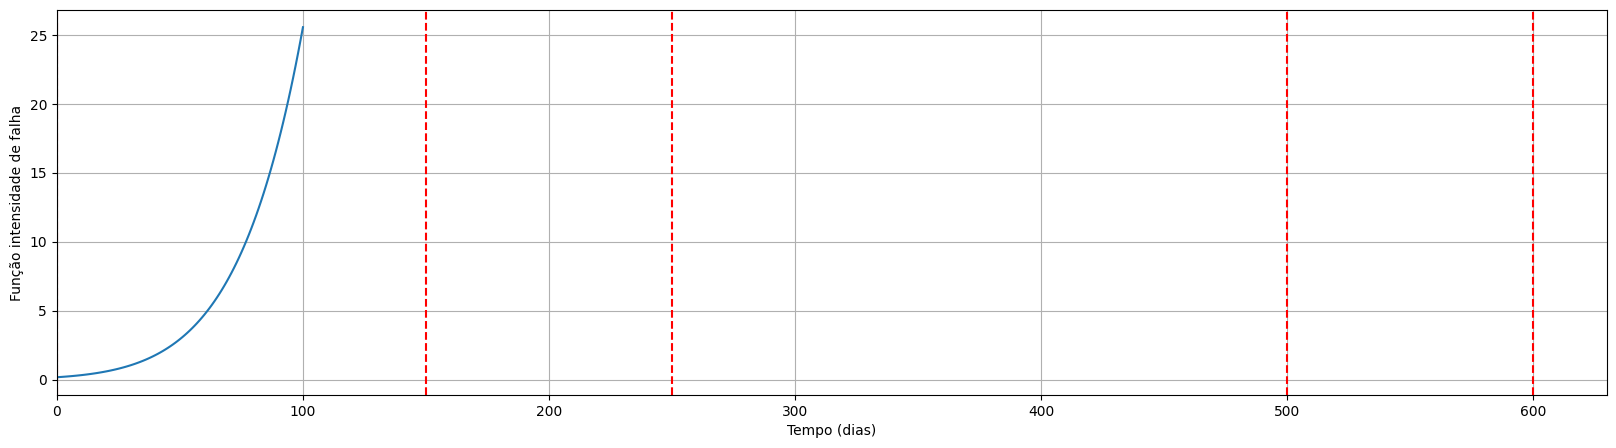

Fator ajuste:  [0.10884396658988782, 0.1341509402084189, 0.22839338634425954, 0.05598938914326168]


In [189]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [190]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [191]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-28 01:53:18,894 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=4.22e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 58, 97, 382, 417, 435, 459, 481, 532, 554, 711]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189]
Media de falhas:  [0, 3.2099448095288204e-11, 0.00047765984169565855, 0.05967706099841921, 49039.55374405323, 67188.83757673082, 121739.2466285541, 182087.36749800915, 268323.8738417488, 687775.6636228082, 1279053.2680706433, 8744398.302272394, -7838490.738794165]
Custo =  968808502.3424761


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 49, 120, 196, 223, 296, 340, 396, 435, 491, 531, 557, 612, 648, 703]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75,

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=4.22e+8

 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 1.6980774516948605, 387.24309290282434, 17455.458991200696, 22450.545816216716, 101439.65408810762, 571020.1707811141, 1442720.698389641, 2523340.752625522, 5813771.384719956, 13270930.836366255, 18431125.722151436, 13877158.723875502]
Custo =  1881786961.100008


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 42, 61, 128, 208, 215, 423, 473, 495, 561, 576, 621, 680]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=4.22e+8

 14 5
Tempos para manutenções preventivas: [0, 83, 90, 137, 204, 214, 379, 406, 491, 510, 562, 580, 632, 686, 719]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.01912831680484355, 0.033672371649095256, 1.1640029771109943, 60.25776423516294, 86.97903187376453, 23575.709358207274, 35127.570479627, 516043.2328093634, 760925.3280330535, 2062120.0205326572, 2274280.2362015215, 6159246.631832597, 10779913.887855338, 15593430.748088341, 10891471.308051575]
Custo =  1606343489.3149915


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 135, 219, 2

pyswarms.single.global_best:  58%|█████▊    |58/100, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 38, 131, 172, 206, 220, 277, 300, 493, 532, 561, 572, 642]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189]
Media de falhas:  [0, 7.75138435325559e-06, 1.5564365191902538, 6.9699374947347055, 52.002397119694244, 97.28281775989085, 1792.531605553176, 2420.9566909564974, 675410.0780425835, 1020196.9821961981, 1852824.4544678982, 1971662.1178043499, 7439866.220042704, 5557208.05948065]
Custo =  699388548.1774427


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 49, 131, 226, 322, 373, 417, 493, 519, 560, 640, 699]
Severidade para cada subsi

pyswarms.single.global_best:  74%|███████▍  |74/100, best_cost=4.22e+8

Custo =  1268261299.829812


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 63, 135, 179, 226, 317, 384, 396, 420, 490, 561, 588, 683, 717]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.0012148700376078216, 1.901038730272366, 15.624003419543527, 144.89735927346462, 7518.148545241848, 20984.229068378267, 29620.591888055955, 43933.48250960862, 283265.31102336675, 1141971.1968024534, 2352254.936917611, 14037406.543317184, 23064830.524339676, 18510863.52606374]
Custo =  1957508749.006618


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0,

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=4.22e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 60, 112, 132, 154, 196, 211, 277, 308, 332, 420, 487, 562, 624, 680]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 0.0007458942613893623, 0.28255179560455246, 0.5649493929880129, 4.601834806486364, 36.22804545492266, 68.72609074782576, 1131.112285114865, 2138.4107669838004, 5197.43821966564, 42511.30068731982, 262461.0688356127, 1166280.331251954, 5047440.457241574, 13129428.776045647, 8408542.759541987]
Custo =  1127476766.2787132


Número de ciclos de manutenção: 10 5
Tempos para manutenções 

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.22e+8
2023-10-28 01:53:20,225 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5083376  1.92381903 3.11415399 0.96567345 3.60537215 0.03116703
 4.75127881 4.27884783 0.87349129 1.20802714 6.3084249  0.86067128
 5.64150639 1.05489724 2.45788517 3.51238424 1.58155455 4.41896104
 1.75904455 1.53298842 5.496653   4.14907055 5.29365075 0.76289452]
2023-10-28 01:53:20,226 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 73, 116, 132, 156, 190, 224, 298, 300, 403, 475, 496, 512, 559, 628, 641, 671]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 0.005299450388383302, 0.3820242520738075, 0.6235777041733643, 5.395266609136176, 26.403698423825112, 125.48395036291063, 2379.522227446465, 2447.2412490387774, 49233.99400850891, 372960.6647464197, 579463.7555864551, 695274.9387197676, 1851252.3345004718, 3183980.108212371, 4587192.416761881, 6946975.600502091, 3027194

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,241 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50377683 1.90345476 3.11239915 0.96794696 3.63190793 2.38544685
 4.73820208 6.37573621 0.87682941 1.20692072 6.30862826 0.86543648
 5.64098549 1.05689358 2.45682178 3.51624278 1.57645922 4.4158621
 1.75841453 1.53195441 5.49755542 4.15121943 5.2817743  0.76294612]
2023-10-28 01:53:20,242 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 49, 75, 114, 133, 187, 217, 304, 341, 374, 391, 430, 494, 562, 610, 645, 682]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 9.846761221077177e-05, 0.0048270079116125835, 0.18451700704772042, 0.47693700836983, 38.213764451003826, 106.38546652450306, 3069.162494084663, 6015.034291367932, 27503.483496739587, 37917.26326257979, 64099.59950818196, 200240.74509485613, 1049529.358635519, 3691646.562818637, 7183464.426711205, 8928595.499292219, 4016

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50296315 1.90659579 3.11150942 0.96918505 3.63206725 4.78957322
 4.72473704 1.43332294 0.87696686 1.20369371 6.30851739 0.86650489
 5.63234814 1.05744221 2.45685077 3.51655966 1.5724338  4.41697703
 1.7585359  1.53298828 5.49645166 4.14781552 5.26443578 0.76247189]
2023-10-28 01:53:20,258 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 36, 93, 133, 163, 183, 223, 368, 420, 496, 562, 596, 609, 653, 676]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 4.5145360182344085e-06, 0.04791882109590577, 0.8305353527112133, 8.886366087535565, 19.5527463895245, 123.86850815970577, 24022.579511361593, 50046.97151938094, 551696.015278253, 1384656.1472950391, 3032976.8124171086, 3914273.983638985, 8578676.576501328, 9644234.363338359, 5290673.533008823]
Custo =  1383136564.9283652


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50354537 1.91336478 3.11130627 0.96994669 3.62854232 0.21223006
 4.71994449 3.97393219 0.87629837 1.20111359 6.30841314 0.86604027
 5.62514531 1.05775902 2.45716108 3.51631326 1.5690916  4.41832472
 1.75874079 1.53391877 5.49546239 4.14488612 5.25425533 0.76208178]
2023-10-28 01:53:20,279 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 133, 188, 226, 307, 402, 499, 562, 580, 608, 669]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 2.1331503847827036, 46.25606140761537, 161.20092128430812, 3293.623153534664, 29425.55715540717, 624588.1540316826, 1432386.39270931, 2188954.913405262, 3883923.724263046, 11243600.69715831, 9347542.986077592]
Custo =  1079885914.0774806


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,305 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50493849 1.92158902 3.11130442 0.97010753 3.6191132  3.76495768
 4.72415484 6.34450458 0.87522021 1.2001033  6.30831977 0.86543941
 5.62069484 1.057294   2.45749228 3.51533106 1.56754759 4.4195657
 1.75899823 1.53474267 5.49486595 4.14269172 5.2471843  0.76194887]
2023-10-28 01:53:20,306 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 135, 162, 199, 226, 273, 321, 340, 390, 500, 562, 609, 663, 708]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 2.4764546494660045, 10.59090278077276, 44.67877229043862, 213.84177519520094, 984.2492483718687, 3004.9637489738548, 4703.674004852385, 45918.213727453316, 419578.0441714634, 1218804.1800448583, 3782369.797712952, 10008823.525134994, 12901248.141639564, 8970759.403453493]
Custo =  1151143831.3151915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50651848 1.9292294  3.11136066 0.96982588 3.60720997 0.42455049
 4.72886542 1.14800807 0.87376664 1.20111359 6.30825631 0.86472607
 5.61758677 1.05630652 2.45787396 3.51390639 1.5674698  4.42054868
 1.75923806 1.53522275 5.49444354 4.14191869 5.2471531  0.76204945]
2023-10-28 01:53:20,331 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 46, 71, 136, 215, 315, 395, 448, 477, 501, 539, 562, 612, 692]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 5.2355617165087735e-05, 0.0027973414586232944, 1.8434172430072322, 71.5206987247482, 4538.162152797216, 24283.6397944568, 111042.17623742086, 211170.71769364772, 463890.20097556757, 845285.4567339863, 1545195.3140968499, 3062350.114130703, 15054756.014065962, 12077584.947060259]
Custo =  1075954885.6542296


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5081386  1.93495361 3.11193575 0.96886446 3.59642622 5.04948208
 4.73455172 3.52722071 0.8723818  1.20357565 6.30820925 0.86392768
 5.62129787 1.05509864 2.45821976 3.51249964 1.56840891 4.42125748
 1.759406   1.53550327 5.49435392 4.14203608 5.25948265 0.76214566]
2023-10-28 01:53:20,348 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 32, 87, 111, 138, 327, 343, 365, 401, 440, 471, 501, 539, 562, 614]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133]
Media de falhas:  [0, 1.390546485821475e-06, 0.024871714606349227, 0.2098184278376138, 1.11203273346633, 7307.201027394294, 10290.061102379785, 13966.944656649192, 57613.0375426063, 89987.98399127659, 183900.10778285505, 485494.22090932616, 866889.4766677448, 1566799.3340306086, 3176104.7164027574, 2176164.9004603243]
Custo =  633430922.5638007


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5096485  1.9399775  3.11306893 0.96770013 3.58752312 2.84650169
 4.74414283 5.68652781 0.8713095  1.20631907 6.30822248 0.86238646
 5.62599789 1.05396448 2.45843206 3.51120242 1.57081939 4.4212335
 1.75945202 1.53522316 5.49433489 4.14381528 5.27462096 0.76241483]
2023-10-28 01:53:20,363 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 118, 140, 280, 303, 415, 435, 465, 501, 563, 616]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133]
Media de falhas:  [0, 0.644798933592236, 2.479411502431709, 1821.2990062679567, 3094.0935263061983, 42503.13975870751, 102029.70891200761, 183363.88701788988, 529182.5105127174, 1341774.5900487625, 4442288.623581015, 3283069.926127266]
Custo =  639086556.229605


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5108529  1.94386676 3.11411671 0.9663797  3.57985666 1.45760017
 4.75424793 0.31171602 0.87042528 1.20921568 6.30829486 0.86091532
 5.63459562 1.05295308 2.45857306 3.51010034 1.57314696 4.42108427
 1.75943951 1.53461011 5.49468255 4.14617122 5.29139555 0.76276269]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 70, 141, 188, 228, 323, 431, 458, 499, 563, 618]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133]
Media de falhas:  [0, 0.003483512778951534, 2.8871810862280363, 40.77996326500417, 169.37475291836492, 3592.394964778547, 94231.39390482607, 159303.6442612642, 524896.8793144143, 1354835.9112408499, 4631860.340047669, 3308922.9512674287]
Custo =  633011946.064254


2023-10-28 01:53:20,438 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 141, 192, 218, 434, 455, 497, 563, 574, 619]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133]
Media de falhas:  [0, 3.825143938530644, 56.74350018073267, 121.75427086208907, 104430.53870236209, 154284.60012812878, 512392.48498049227, 1359305.0050133201, 1800996.6000678758, 4690912.929310374, 3284414.754914442]
Custo =  810477428.7028676


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.51164133 1.94615046 3.11506241 0.96510341 3.57782144 0.67894886
 4.76273569 2.49135192 0.87015418 1.21158239 6.30838788 0.85957252
 5.64398395 1.05240982 2.45849669 3.50925736 1.57556854 4.42038056
 1.75939406 1.53398116 5.49506684 4.14850123 5.30706016 0.76310506]
2023-10-28 01:53:20,509 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 32, 141, 163, 193, 211, 364, 407, 441, 454, 496, 563, 586, 619, 663, 705]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 1.390546485821475e-06, 3.3660445967313697, 10.27492322302705, 32.93773766132816, 53.18391300392643, 15226.077402005036, 46048.328797821814, 100936.03063998677, 117976.88322875916, 469432.58268945024, 1324695.8283674456, 2351136.47291726, 4633105.465942033, 10001697.76493178, 12630211.427909449, 8892896.940312225]
Custo =  1435384937.899325


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.51172431 1.94181723 3.11586134 0.96406119 3.58394763 0.56932875
 4.76737534 4.70602579 0.87039422 1.21357307 6.30847494 0.85859367
 5.65221815 1.05254898 2.45837998 3.50864979 1.57913319 4.41949308
 1.75929669 1.5331883  5.49574094 4.1506164  5.31833427 0.76338764]
2023-10-28 01:53:20,534 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 42, 140, 162, 193, 213, 306, 384, 410, 456, 494, 563, 597, 619, 668, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 2.1084012472844616e-05, 3.0073989432074457, 9.525874064478586, 32.627730286075725, 76.45879635640067, 2119.324945176351, 27693.5175902945, 39951.29342224825, 90967.16062690657, 183232.87493035555, 1054933.4025388823, 2728923.1148925973, 4360112.72587998, 10590416.5071402, 13870526.69202795, 9461027.909930497]
Custo =  1502630912.3022227


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.51087818 1.93500754 3.11612441 0.96341631 3.59314874 1.15201977
 4.76945374 6.60668611 0.8709379  1.21469666 6.30854519 0.8578446
 5.65853712 1.05327396 2.45819185 3.50891157 1.58237775 4.41866732
 1.75916342 1.53244155 5.4965426  4.15240066 5.32306724 0.76358738]
2023-10-28 01:53:20,550 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 54, 117, 139, 190, 218, 307, 354, 365, 411, 458, 494, 563, 617, 672, 709]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.00026012954362070396, 0.45592924738480006, 1.9828333619252494, 45.160347398030346, 113.33574429263643, 2151.3040593726646, 11017.595984485, 18207.052708707815, 53538.34991609481, 233418.21337495733, 321814.4994113372, 1193515.027019864, 4381597.165028641, 11530864.439998563, 14020948.637029931, 10024489.949484946]
Custo =  1254170431.2472014


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,564 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50993362 1.92692428 3.11628138 0.9635087  3.60226485 2.35396253
 4.7684091  1.18873002 0.8720614  1.21515919 6.30858087 0.85746415
 5.66090299 1.0541699  2.45799746 3.50994413 1.58507147 4.4179638
 1.75901997 1.53191676 5.4972878  4.15317884 5.32553073 0.76358961]
2023-10-28 01:53:20,565 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,576 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50887169 1.91945703 3.11596245 0.96363932 3.61064474 3.68176917
 4.76506859 3.50597215 0.87314242 1.2139944  6.30859911 0.85783174
 5.66177291 1.05508226 2.45779083 3.51102331 1.58735005 4.41755724
 1.75889289 1.531



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 138, 152, 185, 226, 305, 462, 493, 562, 616, 656, 675]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 3.085072276685966, 6.1626824081633504, 22.22551557391848, 91.22903480782921, 1852.2062469978341, 215218.51687277414, 292110.78073902597, 1149434.4554188033, 4289687.587695997, 8817732.883723894, 9702595.418950247, 5438001.361020009]
Custo =  1164306551.8384702


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50790012 1.91292029 3.11521676 0.96417234 3.61753873 4.49265698
 4.75835693 5.79151048 0.87415012 1.21193246 6.30860383 0.85838536
 5.66233966 1.05585876 2.45761581 3.51229764 1.58846605 4.41757318
 1.75882181 1.53144136 5.49828394 4.15401323 5.3194751  0.76352035]
2023-10-28 01:53:20,593 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 71, 95, 137, 167, 238, 325, 359, 416, 420, 466, 493, 562, 614, 653, 677, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 0.004014289961760303, 0.04988768638388201, 1.7648098808595942, 7.560018339560109, 269.649467236785, 9510.405396601867, 17659.89419540968, 99177.80574837272, 104453.42493353957, 166808.2263879707, 294854.47977192805, 1152178.1544517053, 4121156.3930937443, 8377976.851837653, 9499735.302595405, 13625683.344340943, 9629224.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 136, 162, 283, 415, 421, 470, 494, 562, 613, 651, 677, 690]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 2.666095253445067, 10.639544753057145, 1830.0651916468519, 46319.982852917914, 50498.574609087154, 121231.03498504599, 239642.46402047324, 1088931.077561136, 3974260.2462725593, 8030021.693928528, 9234153.11642914, 10676715.445604539, 7806140.366948597]
Custo =  1489585324.0109203



2023-10-28 01:53:20,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50715322 1.90753783 3.11454183 0.9647946  3.62281821 5.1386638
 4.75051305 0.50659288 0.87487653 1.20925135 6.30860032 0.85893966
 5.6589167  1.05628203 2.45751358 3.51344506 1.58843659 4.41799855
 1.75876307 1.53169316 5.49813166 4.15377129 5.30756226 0.76343575]
2023-10-28 01:53:20,608 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,623 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50680236 1.90599201 3.11391452 0.96546249 3.62275295 5.09042402
 4.74345455 2.30599075 0.87526876 1.20652688 6.30856506 0.85948259
 5.65495594 1.05654437 2.45751798 3.51432565 1.58795799 4.41864138
 1.75874826 1.53197604 5.49778445 4.15238597 5.29436273 0.76327979]
2023-10-28 01:53



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 135, 153, 284, 364, 419, 420, 472, 495, 562, 612, 651, 677, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 2.4764546494660045, 6.300127501589312, 1987.287990463661, 28694.3998976638, 114244.82793468784, 114954.14611421675, 191806.5615825322, 308222.59493953525, 1149390.5375574152, 3952371.8221712187, 8090391.692649705, 9294523.115150318, 13420471.156895857, 9424012.469350873]
Custo =  1583142973.2807834


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,634 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50676615 1.90958179 3.11339504 0.9661159  3.6218187  4.69261788
 4.73931328 4.14605335 0.8753022  1.20425458 6.30853002 0.86031581
 5.65081881 1.05633105 2.45762287 3.5150276  1.58679608 4.41924241
 1.75874039 1.53250518 5.49732485 4.15101648 5.28239841 0.76310446]
2023-10-28 01:53:20,635 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 79, 135, 210, 351, 417, 473, 496, 562, 595, 611, 651, 677]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 0.011673677197220202, 1.7800441406264123, 84.50705422348736, 15153.597423239129, 43894.34949353521, 314857.14609147876, 378117.8046321418, 1211077.9366489279, 2796585.2097709216, 3892106.0372185893, 8111336.089045328, 9315467.511545941, 4871807.760353377]
Custo =  1387090916.6125615


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,649 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50707622 1.91457505 3.11307067 0.96664263 3.61701881 4.32734467
 4.73687099 5.80573865 0.87532452 1.20242891 6.30848549 0.86108808
 5.64618681 1.05597322 2.45773109 3.51538184 1.58552633 4.41977712
 1.75881519 1.53306818 5.49683964 4.14938708 5.27381409 0.76293326]
2023-10-28 01:53:20,650 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 94, 135, 217, 315, 350, 365, 473, 497, 562, 587, 611, 651, 676]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 0.0663851934888536, 1.69311103040529, 183.63659825955128, 4602.041188694816, 8200.619553347278, 13189.353196383647, 142961.07067251022, 268129.76595995785, 1092793.396273279, 2210909.5930816694, 3770541.8820240395, 7989771.933850778, 9137344.093218809, 4783783.262889273]
Custo =  1351856021.4563496


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50741471 1.92089073 3.11280804 0.96707799 3.60952621 3.92923612
 4.73519538 0.26216051 0.87529137 1.20132833 6.30842948 0.86172185
 5.6407886  1.055507   2.45785111 3.51526103 1.58336825 4.42003195
 1.75894484 1.53355418 5.49634802 4.14789728 5.26943666 0.76276913]
2023-10-28 01:53:20,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 56, 112, 135, 158, 223, 296, 385, 471, 498, 562, 579, 611, 655, 673]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 0.00037419864515468885, 0.28826010643521555, 1.4697314682958653, 4.417511911982644, 139.4565915462555, 2239.1929479832274, 18950.373051510916, 204815.84356605323, 280030.2041944205, 1096307.0684858155, 1804565.219798511, 3780131.174783566, 8578406.95899481, 9398268.874201741, 5308265.58054629]
Custo =  1327785228.7436123


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50790302 1.92662316 3.11296774 0.96720763 3.60216586 3.4131631
 4.73834356 2.37316115 0.87494671 1.20094916 6.30837813 0.86209739
 5.63611075 1.05492638 2.4579646  3.51438721 1.58112125 4.41998429
 1.75909047 1.53395628 5.49595883 4.14658922 5.26572215 0.76264954]
2023-10-28 01:53:20,677 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 50, 137, 225, 345, 366, 470, 499, 562, 573, 612, 671]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00012050800768501927, 2.3337254630451305, 266.5035229495424, 11928.282755797507, 15556.034553574142, 134759.6763759934, 417905.21883237787, 1225703.4575100052, 1660459.9913441218, 3999510.794410816, 11399053.863740942, 9420651.758244794]
Custo =  1107140154.020397


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50846156 1.93152974 3.11320186 0.96705263 3.59589925 2.84706571
 4.74140547 4.80926753 0.87422733 1.20225059 6.3083419  0.86232563
 5.63344953 1.05440051 2.45806365 3.51321439 1.57922766 4.41991633
 1.75921822 1.53431446 5.49562788 4.14592185 5.26378389 0.76260893]
2023-10-28 01:53:20,688 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 47, 106, 138, 165, 225, 299, 339, 375, 467, 499, 562, 613, 668]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 6.491509880027743e-05, 0.1716595475378766, 1.8469809212173036, 10.465354036310499, 151.39070583542374, 4057.4711866997463, 7009.3979451267915, 19732.640284830006, 328274.06365164154, 492195.935698826, 1299994.1743764533, 4185323.3430878767, 10948393.078239068, 9092752.818118256]
Custo =  914441133.0862114


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,701 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50896283 1.93447887 3.11350775 0.9665189  3.5919049  2.40482541
 4.74681937 6.91692012 0.87353368 1.20486971 6.30831055 0.86251826
 5.63140519 1.05398117 2.45810144 3.51206361 1.57795297 4.41956924
 1.75930845 1.53434053 5.49562397 4.14577373 5.26551951 0.76261966]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 45, 88, 119, 139, 179, 221, 384, 465, 499, 562, 570, 614, 665, 690]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 4.2026993187149114e-05, 0.025695198933813525, 0.4229852222907066, 1.2360426290935556, 14.29005607386644, 112.72408679670717, 38406.826317743595, 129569.9869134803, 222199.8741934111, 1029998.1128710384, 1338012.7254367848, 3975100.204027954, 10124988.442735758, 11508230.874753622, 8637655.79609768]
Custo =  1292627474.5233657


2023-10-28 01:53:20,702 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50929706 1.93652761 3.11392707 0.96585237 3.58951733 2.03108766
 4.75269564 1.13417779 0.87290311 1.20795016 6.30830207 0.86246275
 5.62984077 1.05379813 2.45813476 3.51104518 1.57720516 4.4191103
 1.75931834 1.534126   5.49577474 4.14599741 5.26740971 0.76269077]
2023-10-28 01:53:20,713 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 43, 74, 140, 213, 275, 327, 463, 499, 562, 574, 616, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 2.667628908410196e-05, 0.004373735010480833, 2.451906685315945, 95.60317270181353, 1055.4822716673523, 3591.855965705123, 128756.0547028197, 225734.25094887003, 1033532.4896264973, 1511982.1863288, 4138209.0550866383, 9775545.606928604, 8114687.685781388]
Custo =  1060833874.3983495


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,726 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50935518 1.93777998 3.11432453 0.96521854 3.59178247 1.85464456
 4.75775205 2.34753999 0.87248744 1.21073293 6.30832674 0.86228549
 5.63188836 1.05394231 2.45811406 3.51026879 1.57727878 4.41866406
 1.75929138 1.53369635 5.49593441 4.14621464 5.27341753 0.76278326]
2023-10-28 01:53:20,728 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 42, 60, 140, 153, 357, 379, 462, 498, 562, 579, 617, 662]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 2.1084012472844616e-05, 0.0005093522590266342, 2.633226034746062, 4.126202140280525, 22871.889935232764, 40953.00212485519, 192832.20348807547, 369094.7057641209, 1185371.570055516, 1893629.7213682113, 4365917.401326909, 9749481.437998842, 8126160.463468792]
Custo =  1091818472.4667048


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50915003 1.93890492 3.11464389 0.96469131 3.59432086 2.3874063
 4.76081961 3.44438434 0.87235925 1.21254448 6.30835576 0.86180491
 5.63630304 1.05415514 2.45804749 3.51007356 1.57749913 4.41829871
 1.75920216 1.53313176 5.4961906  4.14701618 5.28373576 0.76289009]
2023-10-28 01:53:20,739 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 44, 97, 140, 164, 461, 497, 562, 585, 617, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 3.3569785893685995e-05, 0.07028659203689319, 2.2011796791636455, 6.493738618729191, 326705.4028235481, 499725.6129170167, 1324389.2432303382, 2334907.8275424996, 4496318.1340394635, 10045195.9392182, 8384338.018070985]
Custo =  1108255976.7808113


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 50, 103, 140, 172, 306, 375, 408, 461, 496, 562, 590, 617, 664]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00012050800768501927, 0.1257830722699499, 2.1532133412611967, 6.73112019247019, 4042.2374230601736, 15052.966355008346, 41188.65200867233, 247133.3492527562, 555829.0540805659, 1388789.186097352, 2675070.7624036735, 4557393.270763624, 10274001.052725546, 8575140.805973558]
Custo =  1160549763.157347


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50876013 1.93976554 3.11490282 0.96431756 3.59765361 3.12011319
 4.76281202 4.46520829 0.87225268 1.21289709 6.30838555 0.8612184
 5.64073945 1.05456676 2.45797967 3.51035674 1.57855492 4.41812924
 1.75910158 1.53260159 5.49644126 4.14784679 5.29350247 0.76298699]
2023-10-28 01:53:20,756 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,765 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50839509 1.93672597 3.11506577 0.96400066 3.60118928 4.29989157
 4.76193361 5.37670998 0.87239344 1.21307058 6.30841414 0.86063569
 5.64474749 1.05503633 2.45790631 3.51088732 1.58004658 4.41799345
 1.75900472 1.532



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 55, 139, 339, 401, 462, 495, 562, 594, 617, 666, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00031250989190241535, 2.6507073943488195, 18460.128755594338, 52283.21382690429, 122914.38972815593, 278819.0069791708, 1119986.949597051, 2643689.291196882, 4288704.842287701, 10348146.915675862, 12992505.955955343, 9127191.870743591]
Custo =  1449985604.968812


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 138, 157, 238, 293, 343, 405, 463, 495, 562, 596, 616, 668, 706]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 3.085072276685966, 8.1154386304897, 289.5553413271071, 1929.0660919383442, 8777.450095546232, 74862.30299501792, 300994.19221922336, 382895.1099626123, 1224063.0525804923, 2872383.717702562, 4309339.81001582, 10810987.936527457, 13260694.062909458, 9459768.401725693]
Custo =  1463732271.5049143


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50806013 1.93066943 3.11520183 0.96416155 3.60472917 4.78546308
 4.76104216 6.07530822 0.87256854 1.21273057 6.30844294 0.86011535
 5.6476701  1.05544814 2.45783693 3.5113681  1.58154621 4.41805849
 1.75892158 1.53202235 5.4969033  4.14940178 5.30947562 0.76309705]
2023-10-28 01:53:20,781 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5077836  1.92475589 3.11530283 0.96437235 3.60804482 4.91938697
 4.76016194 6.25759311 0.87284713 1.21146992 6.3084668  0.85978581
 5.64999305 1.05574542 2.45778198 3.51195052 1.58289827 4.41814922
 1.75884893 1.53



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 93, 137, 164, 234, 305, 364, 465, 494, 562, 595, 615, 670]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.05965282819479954, 1.973434125348737, 4.591590662089069, 226.15037292564742, 1861.6898249270512, 15070.183414487878, 322635.9034515146, 460828.7772959495, 1310117.3908366123, 2895624.663958606, 4311428.087676926, 11265212.211900424, 9328235.943876917]
Custo =  1173960079.4745781


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 137, 154, 235, 347, 466, 494, 562, 592, 613, 659, 672]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 2.868706900080017, 6.799177272232033, 256.46955048866147, 19166.357931329403, 218976.64971903586, 470059.03986643784, 1319347.6534071006, 2722408.0256026695, 4156097.263614634, 9402559.546135709, 10000927.762465833, 5996574.948094931]
Custo =  1416183734.8514287


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,807 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50769912 1.91923561 3.11533029 0.96481677 3.6109715  5.59791726
 4.75703588 5.94776559 0.87309881 1.21009936 6.30848097 0.8597312
 5.65198757 1.05592315 2.45775497 3.51252187 1.58386102 4.41838647
 1.75883191 1.53224652 5.49709321 4.15044    5.31474385 0.76312099]
2023-10-28 01:53:20,808 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 61, 117, 136, 238, 290, 300, 341, 375, 467, 494, 562, 589, 612, 658, 673]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 0.0008799326110090484, 0.4407699764136266, 1.0828351209916116, 323.66207649395955, 1765.7101937140524, 2351.1611349633317, 8077.457603031642, 30554.936204219488, 133935.22275945693, 377949.21728437557, 1227237.8308250383, 2456544.1054929076, 3983578.2951103644, 9156766.007407147, 9849841.430933483, 5759838.137278032]
Custo =  1400629550.760239



2023-10-28 01:53:20,818 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50769252 1.91531805 3.11506457 0.96533644 3.61260437 5.361334
 4.75395719 5.50516225 0.87334971 1.20835746 6.30848185 0.85985022
 5.65131675 1.05591258 2.45776963 3.51302427 1.58460026 4.41864919
 1.75881659 1.53257695 5.49710324 4.15073301 5.3099156  0.76306344]
2023-10-28 01:53:20,819 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 70, 136, 468, 495, 562, 585, 611, 657, 673]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133]
Media de falhas:  [0, 0.003483512778951534, 1.9917671906134058, 416160.9428002251, 549058.605101803, 1390226.547719683, 2400745.1320318445, 4068671.9519886393, 9169496.605132258, 9905241.907761436, 5815238.614105985]
Custo =  1358865616.615965


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50771882 1.91372911 3.11470356 0.9658133  3.61320133 5.12207401
 4.75083223 4.84835514 0.8736111  1.2067449  6.30848159 0.86014601
 5.64802223 1.05571052 2.45779044 3.51345246 1.58472429 4.41896844
 1.75886915 1.53288352 5.49702851 4.15066822 5.30361136 0.76299448]
2023-10-28 01:53:20,832 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 77, 93, 136, 160, 352, 468, 496, 562, 582, 611, 658, 674, 717]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 0.009033691809396314, 0.041069114347912786, 1.0457135854683122, 4.449215393606528, 19140.99323101614, 363768.47360189434, 438500.8399937027, 1271460.9720104889, 2127093.2270762473, 3951998.827167996, 9207454.781268455, 9953180.434151525, 15781046.979980703, 11227079.98170477]
Custo =  1827803751.358514



2023-10-28 01:53:20,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50790481 1.91233745 3.11433253 0.96621713 3.61296062 4.79333315
 4.74805149 4.18864431 0.87381883 1.20538454 6.3084711  0.86056186
 5.64375111 1.05536864 2.45781431 3.51369493 1.58475171 4.4192539
 1.75892634 1.53318702 5.49684908 4.15017289 5.29780402 0.76290566]
2023-10-28 01:53:20,847 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,857 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5081859  1.91317932 3.11396864 0.9665141  3.61201548 4.04167803
 4.74651266 3.60519748 0.87397704 1.20469924 6.30845575 0.860962
 5.63958555 1.05502479 2.45784909 3.5138018  1.58392077 4.41950367
 1.759002   1.5334409  5.49664927 4.14945786 5.29253761 0.76282413]
2023-10-28 01:53:2



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 80, 136, 170, 285, 316, 384, 412, 467, 497, 562, 580, 611, 673]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.013238116909674707, 1.913278556250711, 9.258710455733288, 1892.134548972918, 4224.871911238388, 17826.27311425456, 31439.92354047667, 162476.4858717629, 243085.41021406898, 1067749.0405273903, 1824317.5612233425, 3750349.316649697, 11615813.714248728, 9553013.071495447]
Custo =  1111266667.42884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,870 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50845816 1.9150193  3.11364806 0.9665982  3.60984393 3.01966941
 4.74537289 3.27844066 0.87409425 1.20440477 6.30843445 0.86124709
 5.6360276  1.05470083 2.45788619 3.51389706 1.58267988 4.41972408
 1.75907295 1.53365329 5.49646961 4.1487576  5.28789387 0.762759  ]
2023-10-28 01:53:20,871 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 59, 80, 137, 410, 466, 498, 562, 578, 611, 672]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.008960183640590313, 1.8984241769451964, 104298.58201753102, 234250.58441974426, 533971.9456819112, 1350248.809973306, 2010995.0007689835, 4035421.869778417, 11708816.117585883, 9688474.655149324]
Custo =  1125280244.95366


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 56, 78, 92, 137, 152, 290, 375, 390, 465, 498, 562, 579, 612, 670, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.00037419864515468885, 0.006983258766997303, 0.031157044144418895, 1.134730946729047, 1.9864221681202152, 2496.1789665996166, 38892.64303112532, 48032.17179678543, 134561.80404343802, 223329.79628888716, 1039606.6605802821, 1747864.8118929775, 3803002.5713414764, 11016078.291265326, 13800800.8155985, 9669979.621208005]
Custo =  1404366466.406921


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50869202 1.91795279 3.11341448 0.96642546 3.60771367 2.42705325
 4.74532311 3.09725174 0.87406375 1.20493852 6.30841319 0.86144674
 5.63317691 1.05443525 2.45791944 3.51369839 1.58126873 4.4197743
 1.75913206 1.53379679 5.4963549  4.14815171 5.28436665 0.76273848]
2023-10-28 01:53:20,886 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,896 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50889222 1.9217606  3.11335116 0.96613317 3.60511808 2.02741447
 4.74576363 3.25080806 0.87392854 1.20553191 6.30839562 0.86145591
 5.6328478  1.05430138 2.45794908 3.51349836 1.58001173 4.41980069
 1.75916646 1.533



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 54, 74, 137, 156, 340, 464, 499, 562, 581, 613, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00026012954362070396, 0.0041149764051036375, 1.9580603671558545, 4.279970768302932, 13450.262617007917, 209439.18923252233, 304255.29373302707, 1112053.5324106542, 1917742.7348591778, 3953612.8308928753, 10716682.566044068, 8861042.305923255]
Custo =  1093858731.7527964


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 52, 67, 138, 155, 273, 312, 352, 408, 463, 499, 562, 583, 615, 667, 693]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 0.00017836793927853258, 0.001519938800454466, 2.1894142557762777, 4.2217344385397695, 1282.8579768200875, 2624.501899719161, 16407.803182593572, 83603.54994503663, 302875.40748758084, 482434.1289939415, 1290232.3676715689, 2196642.261433373, 4294447.646307239, 10706251.690658081, 12196123.99679456, 9164668.08555275]
Custo =  1381235792.3448043


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50891523 1.92536094 3.11343612 0.96584395 3.60278465 1.97574894
 4.74731994 3.49675174 0.87367915 1.20656814 6.30838648 0.86140166
 5.63278316 1.05418205 2.45795954 3.51323074 1.5791434  4.41976113
 1.75917679 1.53380047 5.49631053 4.1474368  5.28070209 0.76272681]
2023-10-28 01:53:20,912 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 50, 60, 115, 138, 284, 339, 364, 462, 498, 562, 586, 616, 666]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00012050800768501927, 0.0005153692574066969, 0.3447031497809886, 1.1696240096962882, 1558.2073695827544, 8046.559561603624, 15427.153611843556, 112999.9453390013, 208204.77588084905, 1024481.640172244, 2088356.5061243917, 4110041.65249775, 10258456.257757805, 8482171.961289294]
Custo =  1113673270.0225334


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,927 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50888721 1.92851884 3.1136241  0.96554009 3.60083219 2.41744015
 4.7491347  3.91490538 0.87342356 1.2075494  6.30838167 0.86118454
 5.63444352 1.05426853 2.45796771 3.51280913 1.57901123 4.41968369
 1.75915039 1.53368673 5.49635601 4.14769481 5.28045155 0.76273369]
2023-10-28 01:53:20,928 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5088428  1.93124429 3.11392361 0.96529756 3.59950224 3.39358963
 4.75106919 4.33546124 0.87319922 1.20853013 6.30838947 0.86095801
 5.63742118 1.05438902 2.45797215 3.512419   1.57957394 4.41958115
 1.75912109 1.53



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 50, 139, 293, 319, 358, 413, 462, 498, 562, 588, 617, 665, 694]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00012050800768501927, 2.705713571414338, 4102.859243639825, 6347.77080329658, 11153.1737994553, 52639.51726878667, 252969.48250531466, 580062.2210726594, 1396339.0853640544, 2569594.6875149906, 4565828.065833034, 10452613.372339403, 12114074.877759842, 9027665.834829018]
Custo =  1414590546.6398041


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5086644  1.93350112 3.11423666 0.96512369 3.59877671 4.13267121
 4.7528564  4.70505443 0.87299981 1.20927955 6.30839921 0.86068598
 5.64048884 1.05452554 2.45796949 3.51205746 1.58039625 4.41941527
 1.75908523 1.53332918 5.4965627  4.14898054 5.28646382 0.76283702]
2023-10-28 01:53:20,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 105, 139, 164, 307, 354, 462, 497, 562, 590, 618, 666]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 9.846761221077177e-05, 0.15408293784141003, 1.9905317268007177, 4.474761966852791, 4348.5800901839275, 9297.625413162266, 305806.0787526846, 397184.37699180655, 1221848.007305128, 2508129.583611449, 4476831.644454569, 10446183.885613829, 8669899.589145318]
Custo =  1142815984.5248578


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50841345 1.93423956 3.1144945  0.96511444 3.59850343 4.90825805
 4.75445624 4.9400585  0.87293778 1.20970993 6.30841291 0.86044073
 5.64340046 1.0547282  2.4579584  3.51175888 1.58128668 4.41924582
 1.75905251 1.53310557 5.49666847 4.1496292  5.28977872 0.76289943]
2023-10-28 01:53:20,969 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 49, 106, 138, 357, 463, 497, 562, 590, 618, 667]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 9.846761221077177e-05, 0.16982435406664495, 1.8451457277460719, 31487.787751060565, 208407.67575372098, 516261.9096408459, 1340925.5399541673, 2627207.1162604885, 4595909.177103608, 10740253.927135093, 8924536.1227227]
Custo =  1169196997.3180068


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,980 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50816784 1.93387707 3.11464856 0.9652229  3.5993026  6.07565764
 4.75582974 5.02785443 0.87299009 1.21009652 6.30842644 0.86022845
 5.64572882 1.05495867 2.45793527 3.51156395 1.58213687 4.41906735
 1.75902229 1.53286997 5.49676302 4.15018033 5.29354015 0.76295484]
2023-10-28 01:53:20,982 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 50, 138, 285, 322, 335, 463, 496, 562, 590, 617, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00012050800768501927, 2.513532704411793, 3089.209557430948, 6223.003090197279, 7294.012106221842, 202527.00748740797, 288073.09123920294, 1121033.2232559891, 2407314.799562311, 4289637.307922261, 10701959.21653132, 8846318.956410507]
Custo =  1142406639.1290922


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:20,995 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50799184 1.93238756 3.1147518  0.96542382 3.60179964 6.99222005
 4.75571241 5.0638616  0.87311972 1.20996547 6.30843843 0.86014409
 5.64681488 1.05515491 2.45791323 3.51163336 1.58272931 4.41887681
 1.75899547 1.53266368 5.49683683 4.1504821  5.29694452 0.76299806]
2023-10-28 01:53:20,997 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 53, 138, 170, 305, 351, 399, 464, 496, 562, 589, 616, 669, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00021578749232751762, 2.482527764622523, 14.870114564167457, 3947.797006252336, 18499.42196809629, 68415.83684604349, 314217.3890282526, 397650.33499021723, 1230610.4670070033, 2459916.741674873, 4314447.861636426, 10996564.519861335, 13837513.224257402, 9706692.029866906]
Custo =  1462183043.7878559


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,012 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50790843 1.93008794 3.11478302 0.96562729 3.6049142  6.75613674
 4.75517851 4.91953239 0.87330852 1.20944744 6.30844663 0.86009386
 5.64648745 1.0553101  2.45789266 3.51190817 1.58315506 4.4187162
 1.758974   1.53254452 5.49688045 4.15037738 5.29915227 0.76302336]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 57, 119, 137, 270, 321, 347, 386, 465, 495, 562, 587, 615, 670, 718]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.0004466381630574792, 0.5347944911403509, 1.7327435027298335, 1252.6113823443372, 4967.453962905301, 9856.964229428715, 19508.073155015252, 109143.30087961663, 186824.94404234053, 1027992.8866602206, 2146109.083468611, 4028837.409559944, 10982621.533783443, 14450070.527941886, 9822552.824570563]
Custo =  1466597277.824471


2023-10-28 01:53:21,019 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 61, 137, 298, 380, 405, 466, 495, 562, 586, 613, 671, 704]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0008799326110090484, 2.229163816745067, 3595.6653251584207, 27385.35598585172, 37991.082929707336, 285267.315939717, 426054.52828379796, 1267222.470901678, 2331097.3368538255, 4104429.837656204, 11418420.851539643, 13535740.6982621, 9861269.02413432]
Custo =  1431213291.7665699


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,083 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50796098 1.92718598 3.11479186 0.96581598 3.60775002 5.87650625
 4.75381566 4.68669649 0.87352713 1.20882093 6.30845153 0.86019642
 5.64492486 1.05533744 2.45787322 3.51222864 1.58332053 4.41859716
 1.75895548 1.53246448 5.49690838 4.15021265 5.29959579 0.76303344]
2023-10-28 01:53:21,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,249 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50803242 1.92398822 3.11470348 0.96597541 3.61021451 4.10060341
 4.75206056 4.39628566 0.8737145  1.2080513  6.30845302 0.86030715
 5.64346051 1.05527877 2.45785671 3.51255165 1.58331444 4.41850502
 1.75894794 1.53



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 65, 111, 137, 155, 281, 350, 466, 496, 562, 584, 613, 670, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.0016604736651976994, 0.25141622936115676, 1.0764895456945338, 3.1873374604292843, 1751.2312747246779, 19017.359107003518, 349705.7726416788, 428839.01998729614, 1261799.1520040822, 2219833.644216213, 4100335.9047133606, 11228045.153618498, 12426991.829980433, 9503445.129863374]
Custo =  1364131327.1645572


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 67, 137, 320, 357, 467, 496, 562, 583, 612, 670]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0022481295639763888, 2.1743545001711873, 7665.341947550966, 15869.437071258079, 211577.83777300204, 479407.1664999125, 1312367.2985166986, 2218777.1922785034, 4071295.701283929, 11284371.421207778, 9347395.15318427]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50814088 1.92106802 3.11462327 0.96609081 3.61117835 2.51567881
 4.75037936 4.11493123 0.8738537  1.20735542 6.30845414 0.8605053
 5.64196728 1.05511685 2.45784821 3.51279379 1.58305778 4.41852005
 1.75896636 1.53265012 5.4968086  4.14932338 5.29665624 0.76299957]
2023-10-28 01:53:21,313 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  1131903659.0296311


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,403 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50824404 1.91925665 3.11441608 0.96612914 3.61171068 1.2778184
 4.74908475 3.87814944 0.87395987 1.20688698 6.30845509 0.86068445
 5.64049973 1.05493873 2.45784808 3.51295689 1.58269327 4.41865935
 1.75899049 1.53280289 5.49675515 4.14880418 5.29386342 0.76295114]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 69, 113, 137, 161, 344, 395, 467, 497, 562, 583, 612, 669]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0030167536030559624, 0.2966992024984706, 1.0858227090216226, 4.694628165907666, 14920.444273006935, 40980.576815655295, 128564.8597828765, 209173.78412518257, 1033837.4144385039, 1940247.3082003086, 3792765.817205734, 10822029.085939152, 8925971.374858433]
Custo =  1100101701.891812


2023-10-28 01:53:21,451 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 70, 137, 329, 394, 467, 497, 562, 582, 613, 668, 715]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 0.003483512778951534, 2.1476588609874305, 10284.346817308744, 39739.83266769691, 195915.51718335252, 476004.00203463656, 1300667.632347958, 2156299.8874137164, 4141085.7687012246, 10904155.503852416, 14184265.688740166, 9774766.906642713]
Custo =  1450298952.860058


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,591 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50835283 1.91890794 3.11415476 0.9661111  3.61122392 0.80812002
 4.74815927 3.68863972 0.87404588 1.20675759 6.30845105 0.86084524
 5.63918669 1.05477783 2.45785195 3.51304637 1.58213485 4.41882748
 1.75901751 1.53296978 5.49668358 4.1483372  5.29128722 0.76289308]
2023-10-28 01:53:21,605 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,707 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50844838 1.91938276 3.11391955 0.96603892 3.61051666 0.88165371
 4.74756364 3.57511734 0.87405174 1.20684207 6.30844017 0.86097368
 5.63822744 1.05466024 2.45786338 3.51293184 1.5814963  4.41898246
 1.75904557 1.53



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 71, 138, 289, 354, 466, 498, 562, 583, 613, 667]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.004014289961760303, 2.3050491588392683, 2580.171106959771, 13310.443977177902, 129104.46892152443, 215678.14349716558, 1031955.0077885606, 1938364.9015503651, 3871364.768908959, 10456009.87599881, 8640292.071586417]
Custo =  1093239683.6900978


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,723 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50850495 1.9202065  3.11371562 0.96593487 3.60877872 1.49231147
 4.74779967 3.47572952 0.87397213 1.20707043 6.30842707 0.8610468
 5.63784721 1.05460738 2.4578796  3.51273453 1.5809235  4.41911928
 1.75907073 1.53324201 5.4965517  4.14773779 5.28848197 0.76280033]
2023-10-28 01:53:21,725 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 69, 108, 138, 271, 309, 346, 466, 498, 562, 584, 613, 667]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0030167536030559624, 0.18614030250435207, 1.1408880897238771, 1832.6862011839196, 4001.989543838413, 15184.783773040785, 136659.78942299003, 436381.15068515704, 1252658.014976552, 2210692.5071886824, 4091194.7676858297, 10675839.874775682, 8860122.070363289]
Custo =  1123745736.1703026


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 67, 104, 138, 166, 297, 404, 465, 498, 562, 585, 614, 666, 714]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.0022481295639763888, 0.12732050471556608, 1.1469583239999117, 4.15143292909913, 3012.3822587334666, 84093.58775622255, 218600.83851852253, 383437.47727459104, 1199714.341565986, 2210232.925878147, 4119094.131864378, 10442160.009885151, 13736103.598731518, 9397542.036973998]
Custo =  1435091470.186495


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50855025 1.92166031 3.11356806 0.96579695 3.60639897 2.38255143
 4.74851062 3.47468985 0.8738867  1.20729011 6.30841509 0.86102942
 5.63782092 1.05461405 2.45789524 3.51246721 1.58052029 4.41923829
 1.75908942 1.53331528 5.49652324 4.14768257 5.28893106 0.76277801]
2023-10-28 01:53:21,740 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50853002 1.9234357  3.11357849 0.96567262 3.60425278 3.49977337
 4.74925602 3.5804707  0.87369979 1.20757231 6.30840576 0.8609557
 5.63874532 1.05464993 2.45790817 3.51220298 1.58022373 4.41927136
 1.75910034 1.533



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 64, 112, 138, 160, 464, 498, 562, 586, 614, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0014220373876425419, 0.27708470050948686, 1.1608443108781863, 6.956933867349572, 353995.65760793386, 522694.27221458365, 1338971.1365059786, 2402846.0024581263, 4257667.559635524, 10580733.437656296, 8804449.141187785]
Custo =  1111854525.1692047


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,772 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50846484 1.92506487 3.11360658 0.96556095 3.6025349  4.76437914
 4.75032009 3.87504011 0.87347904 1.20793329 6.30839984 0.86086368
 5.63999113 1.05473176 2.45791885 3.51201949 1.58022796 4.41925713
 1.7591031  1.53331984 5.49652696 4.14837958 5.29143591 0.76280276]
2023-10-28 01:53:21,773 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 58, 62, 99, 138, 158, 349, 464, 498, 562, 587, 615, 666]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0005314627054076668, 0.0008373061210333573, 0.07176700335093868, 1.1670899519302143, 2.6705940256970706, 17615.625924861863, 130915.57929789241, 299614.1939045422, 1115891.0581959372, 2234007.2550043277, 4116735.581095661, 10353019.9865025, 8576735.690033989]
Custo =  1119810835.9486907


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50836949 1.92623088 3.11367249 0.96548956 3.60123247 6.3292336
 4.7513491  4.23119635 0.87328101 1.20827809 6.30839874 0.86076982
 5.64145389 1.05481938 2.45792463 3.51187397 1.58023574 4.41924135
 1.75909175 1.53320295 5.49657187 4.14886619 5.29279305 0.76281893]
2023-10-28 01:53:21,794 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 56, 60, 107, 138, 464, 497, 562, 588, 615, 666]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00037419864515468885, 0.0006000029488683798, 0.1631449064915986, 1.1345957499495742, 461284.68319191056, 623094.6956282842, 1447758.3259416055, 2621013.928092541, 4448119.051128914, 10684403.456535753, 8908119.160067242]
Custo =  1123980853.5683846


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,804 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50827816 1.92688947 3.11386374 0.96543663 3.60045595 1.20872945
 4.75226203 4.56516843 0.87315445 1.20851655 6.30840168 0.86068077
 5.64277578 1.05491363 2.45792623 3.51186763 1.58061382 4.41921005
 1.75907286 1.53307753 5.49663657 4.14933542 5.29405677 0.76283586]
2023-10-28 01:53:21,806 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 54, 96, 138, 463, 497, 562, 588, 615, 667]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00026012954362070396, 0.05961666928108298, 1.8995765950583117, 306351.79128556035, 471950.9740619884, 1296614.6043753098, 2469870.206526246, 4296975.329562618, 10708779.373913461, 8893061.569501068]
Custo =  1126802382.916273


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,827 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50820044 1.9268513  3.11404065 0.96544627 3.60054085 3.30446734
 4.75295243 4.79049706 0.87308751 1.20862044 6.30840433 0.86059914
 5.64394287 1.05499496 2.45791896 3.51198135 1.58103564 4.4191451
 1.75904873 1.53295005 5.4966953  4.14968248 5.29517972 0.762855  ]
2023-10-28 01:53:21,828 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 53, 92, 138, 328, 336, 369, 407, 463, 497, 562, 588, 615, 668]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00021578749232751762, 0.03867131135458884, 1.9326128384315435, 13172.49818114409, 14516.462978724245, 20127.654835494704, 35575.72691105634, 257173.83865603173, 422773.0214324598, 1247436.6517457813, 2420692.253896717, 4247797.376933089, 10837669.30468486, 8982029.044564048]
Custo =  1147004781.6875422


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50815305 1.92612907 3.11420858 0.96550084 3.60104194 4.95554607
 4.75355195 4.85747336 0.87313041 1.20863628 6.30841158 0.86054463
 5.64441919 1.05505089 2.4579084  3.51213855 1.58154878 4.41906636
 1.75902661 1.53283622 5.49674416 4.1499388  5.29598007 0.7628804 ]
2023-10-28 01:53:21,843 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 53, 137, 327, 464, 497, 562, 587, 615, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00021578749232751762, 2.30472792635175, 12793.134591756829, 219300.8973022518, 520387.3689724149, 1345050.9992857361, 2463167.1960941264, 4345895.52218546, 10935767.449937232, 9080127.189816419]
Custo =  1147907365.1633976


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50811094 1.925467   3.11435747 0.96559531 3.60246639 5.67284806
 4.7539496  4.77399924 0.87323318 1.20853021 6.30842068 0.8605208
 5.64468676 1.0550674  2.4578924  3.51229449 1.58201226 4.4189764
 1.75901109 1.53274893 5.49678281 4.14991192 5.29651558 0.76290708]
2023-10-28 01:53:21,857 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 53, 137, 319, 366, 419, 464, 497, 562, 586, 615, 669, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00021578749232751762, 2.30472792635175, 9912.18067313403, 22029.05369810116, 47830.563350169, 245409.65753492853, 546496.1292050916, 1371159.7595184129, 2435034.6254705605, 4372634.36606214, 11143155.253365945, 14366348.233872104, 9956849.45177465]
Custo =  1487743352.2463994


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,869 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50811441 1.92449712 3.11443764 0.96568161 3.60398316 5.95507811
 4.75387186 4.56054984 0.87338194 1.20832454 6.30842929 0.86052001
 5.64454006 1.05505139 2.45787583 3.51244521 1.58240078 4.41889184
 1.75900404 1.53267088 5.49681354 4.14982797 5.29656906 0.76292969]
2023-10-28 01:53:21,871 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 54, 137, 151, 283, 464, 496, 562, 586, 615, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00026012954362070396, 2.295140110684541, 4.8562273277602745, 1931.7191278400435, 243072.32347780248, 531849.9946800742, 1364810.1266968604, 2428684.992649008, 4366284.733240588, 11136805.620544393, 9240747.909463674]
Custo =  1147973062.9130502


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,888 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50816569 1.92352381 3.11442659 0.9657582  3.6056422  6.17169443
 4.75321718 4.34498081 0.87354465 1.20813882 6.3084365  0.86052838
 5.64413222 1.0550011  2.45786208 3.51257944 1.58250608 4.4188325
 1.75900494 1.53264897 5.496814   4.14973433 5.29606741 0.7629435 ]
2023-10-28 01:53:21,889 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 55, 60, 137, 289, 322, 465, 496, 562, 585, 615, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00031250989190241535, 0.0005773022280483974, 2.106356392826108, 2592.8386172870746, 5494.55539605867, 140721.23215631492, 222016.72843285522, 1054976.8604496415, 2065495.444761803, 4057225.085328662, 10827745.972632466, 8931688.261551747]
Custo =  1117919506.4110632


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 57, 62, 110, 137, 329, 408, 465, 497, 562, 584, 614, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0004466381630574792, 0.0008059468982560262, 0.21464114455329994, 1.0569062718987605, 10283.256064719655, 55966.62581846079, 289129.0173220785, 447096.134671027, 1271759.7649843483, 2229794.257196479, 4191963.6621576315, 11049800.926637795, 9153743.215557076]
Custo =  1133864824.4303627


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,904 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50825041 1.92273252 3.11439363 0.96581111 3.60707403 6.49976986
 4.75240692 4.14590446 0.87367627 1.20794373 6.30844265 0.86054033
 5.64318544 1.05494879 2.45785112 3.51267545 1.58248381 4.41880875
 1.75900745 1.5326705  5.49678575 4.14954214 5.29550611 0.76295464]
2023-10-28 01:53:21,906 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,919 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50835266 1.9222592  3.11432707 0.96585664 3.60792607 5.81005483
 4.75137472 3.9893112  0.87376798 1.20777303 6.30844346 0.86058155
 5.64215263 1.05489428 2.45784469 3.51272685 1.58236609 4.41879443
 1.75901516 1.53



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 58, 63, 137, 318, 341, 373, 466, 497, 562, 584, 614, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0005314627054076668, 0.0009484359947331353, 2.0736833202457636, 7172.053879973823, 10961.638637666534, 17015.390478555015, 320661.975862189, 403474.25888580614, 1228137.8891991274, 2186172.381411258, 4148341.786372411, 11006179.050852574, 9110121.339771856]
Custo =  1120549354.5567727


2023-10-28 01:53:21,921 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,932 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50844091 1.92211632 3.11422692 0.9658535  3.60834619 5.38392179
 4.75041814 3.88471988 0.87381434 1.2076483  6.30844263 0.8606277
 5.64108488 1.05484539 2.45784093 3.51276287 1.58220279 4.41880186
 1.75902436 1.53284425 5.49665957 4.14904912 5.29421004 0.76293123]
2023-10-28 01:53:21,934 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 59, 65, 138, 360, 466, 497, 562, 584, 614, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.0012618273475302512, 2.212360101122716, 26515.007817437272, 214596.07709953835, 501801.6985845424, 1326465.3288978636, 2284499.8211099943, 4246669.226071147, 11104506.49055131, 9208448.77947059]
Custo =  1139862848.9421227


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 66, 138, 159, 303, 369, 390, 466, 497, 562, 585, 614, 668, 704]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0019343057733282806, 2.352694186427903, 5.310181314373704, 3868.540823404874, 13062.332464544088, 19553.946107393236, 176244.95182877933, 463450.5733137834, 1288114.2036271049, 2298632.7879392663, 4207493.993925497, 10884501.710692754, 13164933.55577371, 9490461.88164593]
Custo =  1426291812.206831



2023-10-28 01:53:21,949 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50851004 1.92205732 3.11411598 0.9658326  3.60866506 5.67752724
 4.74969893 3.8549412  0.8738197  1.20754405 6.30843677 0.86067757
 5.64021095 1.05480471 2.45784496 3.51274097 1.58190896 4.41883516
 1.75903315 1.53296726 5.49660396 4.14883541 5.29353988 0.76290928]
2023-10-28 01:53:21,951 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,962 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50855565 1.92207633 3.11401793 0.9657672  3.60802856 6.50440221
 4.74922192 3.93066576 0.87380464 1.20756647 6.30843087 0.86072083
 5.63968187 1.05477295 2.45785826 3.51261779 1.58154943 4.41888762
 1.75904184 1.53308305 5.49656029 4.14865057 5.29294611 0.76288859]
2023-10-28 01:5



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 66, 138, 283, 302, 351, 384, 397, 465, 497, 562, 585, 614, 668, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.0019343057733282806, 2.352694186427903, 2062.163725833887, 3127.746277872382, 11527.677832106978, 39005.35265442286, 56916.65378670157, 137827.42598825548, 222817.8345930091, 1047481.4649063305, 2058000.0492184917, 3966861.2552047228, 10643868.97197198, 12013427.445289737, 9036256.378284033]
Custo =  1367271787.7226222


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:21,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50855664 1.92219074 3.11394382 0.96568889 3.60705978 6.83804484
 4.74921525 4.06168263 0.87370975 1.20762088 6.30842478 0.86075236
 5.63965864 1.05475174 2.45787163 3.51249407 1.58122639 4.41894168
 1.75904993 1.53317321 5.49653066 4.14852281 5.29254153 0.7628709 ]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 66, 138, 165, 329, 359, 361, 465, 497, 562, 585, 614, 668]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0019343057733282806, 2.352694186427903, 7.224884320794111, 9108.012230813229, 16557.09121239603, 17242.869239653694, 199695.1054312122, 493899.37600452115, 1318563.0063178425, 2329081.5906300037, 4237942.796616235, 10914950.513383493, 9059310.25326268]
Custo =  1139913185.3509512


2023-10-28 01:53:21,991 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 59, 65, 138, 165, 353, 365, 465, 497, 562, 585, 614, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.0012618273475302512, 2.212360101122716, 7.084550235488924, 19333.943642787082, 23443.204816720605, 128509.03272416691, 286476.1500731154, 1111139.7803864367, 2121658.364698598, 4030519.5706848293, 10707527.287452087, 8851887.027331274]
Custo =  1119262878.1791892


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50855587 1.92232908 3.11390983 0.96561541 3.60607058 5.85074385
 4.74952465 4.20393068 0.87359203 1.20773446 6.3084193  0.86075802
 5.64014616 1.05477148 2.45788655 3.5123553  1.58097511 4.41899283
 1.75905703 1.53324779 5.49652629 4.14853099 5.29248489 0.76285603]
2023-10-28 01:53:22,011 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 57, 64, 138, 167, 292, 364, 465, 497, 562, 586, 614, 667, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 0.0004466381630574792, 0.0010482964680685154, 2.2238023708937815, 7.909560976086154, 2497.966772789128, 17265.55780585213, 123040.85974172584, 208031.26834647945, 1032694.8986598009, 2096569.7646119485, 3951391.3217893457, 10450152.862156067, 13309710.026837358, 9246476.936419122]
Custo =  1412983253.499285



2023-10-28 01:53:22,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50854687 1.92267853 3.11391915 0.96555001 3.60497156 4.64701699
 4.75017215 4.34817089 0.87347476 1.20789352 6.30841565 0.86075755
 5.64098097 1.05481119 2.45789986 3.51223759 1.58089508 4.41903446
 1.75906186 1.53326462 5.49652511 4.14861451 5.29265575 0.76284927]
2023-10-28 01:53:22,028 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 56, 63, 138, 159, 303, 464, 497, 562, 586, 614, 667]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00037419864515468885, 0.0008930944307189656, 2.2353419048993333, 5.192829032845134, 3868.4234711233457, 229249.90394989983, 316393.69976148044, 1141057.3300748018, 2204932.196026949, 4059753.7532043466, 10558515.293571066, 8742797.489158673]
Custo =  1108181177.693949


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50852155 1.92321573 3.1139326  0.96550133 3.60401459 3.8019852
 4.75082683 4.47493867 0.87337008 1.20806595 6.30841406 0.86073932
 5.6418894  1.0548637  2.45790868 3.51214076 1.58090575 4.4190672
 1.75906315 1.53323193 5.49655035 4.1487013  5.29289404 0.76285449]
2023-10-28 01:53:22,043 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50849701 1.92387517 3.11394736 0.96549795 3.60349071 3.69407293
 4.75142635 4.55211342 0.87329272 1.20821352 6.30841266 0.86070495
 5.64263823 1.05491163 2.45791504 3.51208488 1.58109708 4.41909004
 1.75906269 1.5331



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 56, 62, 138, 151, 285, 302, 464, 497, 562, 586, 614, 668, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.00037419864515468885, 0.0007800608032709302, 2.246964569109003, 3.5684777347065495, 2082.3430790264474, 3057.4082861276756, 229221.76060653213, 530308.2322766952, 1354971.8625900166, 2418846.728542164, 4273668.285719561, 10950676.002486818, 14230786.187374568, 9821287.405277114]
Custo =  1462534591.088042


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 55, 61, 138, 307, 385, 419, 464, 497, 562, 586, 615, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00031250989190241535, 0.0006610786055517531, 2.2586240845252834, 4912.058057536295, 31123.191025667315, 49668.765749236736, 108613.11537310536, 195756.91118468595, 1020420.5414980073, 2084295.407450155, 4021895.1480417345, 10611767.075793505, 8756126.815672692]
Custo =  1121267040.5428913


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50845373 1.92446082 3.11401572 0.96552136 3.60314074 4.28906725
 4.75193125 4.56785231 0.87326054 1.20830959 6.30841423 0.86067216
 5.64302329 1.05495439 2.45791186 3.5120874  1.58138764 4.41908947
 1.75906103 1.53302986 5.49664062 4.14904798 5.29362034 0.7628697 ]
2023-10-28 01:53:22,070 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50839121 1.92493871 3.11408165 0.96558458 3.60286829 4.71377091
 4.75235267 4.51046154 0.87329825 1.20837233 6.30841766 0.86064239
 5.64330857 1.05498632 2.45790529 3.5121337  1.5816709  4.41907418
 1.75905882 1.53



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 55, 61, 138, 340, 378, 406, 464, 497, 562, 586, 615, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00031250989190241535, 0.0006610786055517531, 2.2586240845252834, 14502.931822325298, 28730.28932807163, 50791.56704200996, 281569.41557811596, 443379.4280144897, 1268043.058327811, 2331917.924279959, 4269517.664871538, 10859389.592623308, 9003749.332502495]
Custo =  1142287493.033757


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 55, 61, 115, 137, 278, 368, 465, 497, 562, 586, 615, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00031250989190241535, 0.0006610786055517531, 0.3426298104061119, 1.0933947701399533, 1711.8246936534777, 20147.023572954404, 123074.50219688972, 208064.91080164333, 1032728.5411149648, 2096603.4070671124, 4034203.1476586917, 10804724.034962496, 8908666.323881777]
Custo =  1122490726.2962382


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50832206 1.9251715  3.11416189 0.96565603 3.60274009 5.46904084
 4.75244371 4.44509068 0.87333926 1.20838534 6.30842102 0.86061922
 5.64355164 1.05500976 2.45789554 3.51220852 1.58191139 4.41903001
 1.75905566 1.5328416  5.49671807 4.14936523 5.294219   0.76288969]
2023-10-28 01:53:22,098 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,114 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50826219 1.92534685 3.11423217 0.96572072 3.60339422 5.89875372
 4.75248289 4.34662644 0.87340242 1.20834405 6.3084251  0.8606093
 5.64320637 1.05500542 2.45788451 3.51228546 1.58204087 4.41897907
 1.75905232 1.532



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 56, 61, 137, 152, 282, 316, 379, 403, 465, 497, 562, 585, 615, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00037419864515468885, 0.0006830472949115088, 2.0954066817796746, 3.6507509492621573, 1848.7528304634304, 4333.9371704740615, 39779.55197184007, 58036.12516722992, 302539.22073488083, 387529.62933963444, 1212193.259652956, 2222711.8439651174, 4214441.484531976, 10984962.37183578, 9088904.66075506]
Custo =  1135534957.3200636


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 57, 62, 137, 173, 332, 465, 497, 562, 585, 615, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0004466381630574792, 0.0008059468982560262, 2.0845153976802555, 11.022717965848145, 9697.189025625528, 217193.63084175298, 375160.7481907015, 1199824.378504023, 2210342.9628161844, 4202072.603383044, 10972593.490686849, 9076535.77960613]
Custo =  1129724149.6174622



2023-10-28 01:53:22,128 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50820987 1.92506028 3.11429184 0.96577565 3.60456728 6.68889992
 4.75251735 4.24292456 0.87348333 1.20823258 6.30842876 0.86061304
 5.64245117 1.05497706 2.45787469 3.51237756 1.58214529 4.41893043
 1.75904749 1.53275142 5.49675766 4.1494368  5.29424042 0.76290774]
2023-10-28 01:53:22,129 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 58, 63, 95, 138, 273, 313, 332, 465, 497, 562, 585, 615, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0005314627054076668, 0.0009484359947331353, 0.046400399163499306, 1.1998427825209113, 1977.8874354184281, 4506.150674095608, 9265.235799829126, 137415.68274770558, 222406.0913524592, 1047069.7216657805, 2057588.305977942, 4049317.946544801, 10819838.833848605, 8923781.122767886]
Custo =  1119285266.1529725


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,145 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50817539 1.92477272 3.11433133 0.96581883 3.60585819 6.23799985
 4.75250389 4.15394896 0.87355702 1.20810045 6.30843139 0.86063162
 5.64158601 1.0549472  2.45786668 3.51246048 1.58208407 4.4188928
 1.75904241 1.53275501 5.49676535 4.14935042 5.29400263 0.76291275]
2023-10-28 01:53:22,146 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50814921 1.9242745  3.11433055 0.96582439 3.6068793  6.45872568
 4.75239787 4.10587793 0.87361466 1.20797373 6.30843203 0.86065867
 5.64080218 1.05491159 2.45786328 3.51253325 1.58195025 4.41887163
 1.75903786 1.532



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 59, 63, 102, 138, 385, 396, 465, 497, 562, 585, 614, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.0009851358974880312, 0.09727614751752649, 1.1477475209097776, 42732.088658930494, 50721.227340837344, 195786.88214569015, 353753.99949463864, 1178417.62980796, 2188936.214120121, 4097797.4201063523, 10955634.684586514, 9059576.973505795]
Custo =  1130205573.5233803


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50816256 1.92374592 3.11427908 0.96580357 3.60779493 0.22093304
 4.75205411 4.08499934 0.87362983 1.20787409 6.30843135 0.86068363
 5.64011316 1.05487828 2.45786487 3.51259091 1.5817735  4.41886631
 1.75903428 1.53284295 5.49673625 4.14911734 5.29351498 0.76291449]
2023-10-28 01:53:22,175 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 59, 64, 138, 161, 272, 338, 466, 497, 562, 585, 614, 669, 701]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 0.0006305199138642497, 0.001113247307498145, 2.223867321733211, 5.741259805671621, 1194.5399302379346, 5250.733222690227, 347409.46377871593, 501478.9778530012, 1326142.6081663226, 2336661.192478484, 4245522.398464715, 11103359.662944878, 13086465.908452252, 9596000.1102251]
Custo =  1405522663.9838705


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50818101 1.92328832 3.11420259 0.9657646  3.60810295 1.5821121
 4.75168803 4.11373044 0.87362616 1.20782375 6.30842886 0.86070559
 5.63981657 1.05485026 2.45787143 3.51261053 1.58160358 4.41888291
 1.7590329  1.53290753 5.4966888  4.14900822 5.29331581 0.76291385]
2023-10-28 01:53:22,187 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 59, 64, 138, 153, 465, 497, 562, 585, 614, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.001113247307498145, 2.223867321733211, 3.8770435934192777, 369810.9282323745, 454801.3368371281, 1279464.9671504495, 2289983.5514626107, 4198844.757448842, 11056682.021929003, 9160624.310848285]
Custo =  1113818102.1140056


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50823502 1.92295869 3.11412771 0.9657092  3.60817073 3.08007787
 4.75133086 4.17440421 0.87362048 1.20781731 6.30842632 0.86072075
 5.63961081 1.05483694 2.45788136 3.51259298 1.58144085 4.41890198
 1.75903194 1.53296944 5.49663874 4.14892699 5.29317935 0.76290855]
2023-10-28 01:53:22,204 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 59, 64, 138, 156, 293, 323, 346, 375, 395, 465, 497, 562, 585, 614, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.001113247307498145, 2.223867321733211, 4.465399289867273, 2735.718291088209, 4261.2724902781865, 12325.412677692248, 32463.439960306932, 57003.24750115792, 139545.62066369216, 433749.89123700117, 1258413.5215503224, 2268932.105862484, 4177793.311848715, 10854801.028615972, 8999160.76849516]
Custo =  1144397592.580827


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50829528 1.92270357 3.11406725 0.96565137 3.60774901 5.08064856
 4.75100054 4.23291033 0.87359162 1.2078388  6.30842388 0.86072034
 5.63976802 1.05483071 2.45789053 3.51252743 1.58131163 4.41893078
 1.75903362 1.53302575 5.49659677 4.14889171 5.29311324 0.76290003]
2023-10-28 01:53:22,216 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 59, 64, 112, 138, 151, 298, 367, 396, 465, 497, 562, 586, 614, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.001113247307498145, 0.2556278407501907, 1.1393874511188902, 3.5757770485481375, 3361.7007731835074, 12366.708951863202, 22094.03479942026, 280950.4404230268, 365940.8490277804, 1190604.4793411018, 2254479.3452932495, 4109300.9024706464, 10786308.619237904, 8930668.35911709]
Custo =  1124373160.247731


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 58, 64, 112, 138, 465, 497, 562, 586, 614, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0005314627054076668, 0.0010776233931150537, 0.25559221683580763, 1.1393518272045071, 320688.4742075588, 478655.5915565073, 1303319.2218698286, 2367194.0878219763, 4222015.644999374, 10899023.36176663, 9043383.101645818]
Custo =  1120454586.7970195


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50835343 1.92279735 3.11402066 0.96560578 3.60732247 0.01183409
 4.75078145 4.29779064 0.87356506 1.20786055 6.30842194 0.86071098
 5.64001516 1.05484288 2.45789781 3.51245866 1.58120281 4.41896301
 1.75903738 1.53306583 5.49657123 4.1488873  5.29309089 0.7628923 ]
2023-10-28 01:53:22,231 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 58, 64, 138, 285, 308, 345, 465, 497, 562, 586, 614, 668, 690]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.0005314627054076668, 0.0010776233931150537, 2.2238316978188277, 2223.227452230424, 3703.935355401073, 6985.920577954484, 334791.41426948557, 628995.6848427946, 1453659.315156116, 2517534.1811082633, 4372355.738285661, 11049363.455052918, 12283309.207066149, 9412734.128410207]
Custo =  1387940739.356317


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50840547 1.92294265 3.113988   0.96557677 3.60642638 2.45344717
 4.75063329 4.35284349 0.8735203  1.20793006 6.30842067 0.86069956
 5.64026625 1.05486617 2.45790189 3.51237894 1.58116737 4.41899196
 1.75904217 1.53308685 5.49656393 4.14890851 5.29322203 0.76288536]
2023-10-28 01:53:22,248 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 57, 64, 111, 138, 347, 391, 465, 497, 562, 586, 614, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0004466381630574792, 0.0010482964680685154, 0.232807076824449, 1.1350213824531652, 13925.082906732407, 35458.78411032333, 186650.88341045976, 344618.0007594082, 1169281.6310727296, 2233156.497024877, 4087978.0542022744, 10764985.770969532, 8909345.51084872]
Custo =  1126928501.1366704



2023-10-28 01:53:22,262 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5084382  1.92316578 3.113968   0.96556499 3.60550645 5.08644255
 4.75058147 4.38961003 0.87347791 1.20801456 6.3084199  0.86068784
 5.64055296 1.05488982 2.45790454 3.51230808 1.58121968 4.41901256
 1.75904718 1.53308759 5.49657267 4.14895583 5.29340893 0.76287924]
2023-10-28 01:53:22,263 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50844795 1.92346631 3.11397389 0.96557693 3.60466599 0.5478276
 4.75065306 4.39868122 0.87344309 1.20809331 6.30842037 0.86067695
 5.64096225 1.05491218 2.45790449 3.51225289 1.5812967  4.41902892
 1.75905105 1.53306873 5.49659768 4.14900979 5.293613   0.76287753]
2023-10-28 01:53



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 57, 63, 138, 296, 343, 373, 465, 497, 562, 586, 614, 668, 691]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0004466381630574792, 0.0009180250558817901, 2.235366835524496, 3330.587782485861, 9925.22505379144, 15683.316485572606, 115007.67751622344, 409211.94808953244, 1233875.5784028538, 2297750.4443550017, 4152572.001532399, 10829579.718299657, 12130788.246710144, 9207241.546593085]
Custo =  1384943134.6834717


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50842393 1.92377255 3.11402321 0.9656109  3.60400757 3.44431646
 4.7508125  4.40530657 0.87342071 1.20816039 6.30842096 0.86066682
 5.64146974 1.05492946 2.45790398 3.51224042 1.58136949 4.41902772
 1.75905326 1.53304714 5.49662069 4.14907466 5.29380702 0.76288002]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 56, 63, 116, 138, 152, 290, 397, 465, 497, 562, 586, 615, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00037419864515468885, 0.0008930944307189656, 0.37026081274575245, 1.1742374433887413, 1.9827873219860472, 2496.1753317534826, 27768.561454711387, 284675.418992736, 442642.5363416845, 1267306.166655006, 2331181.0326071535, 4268780.773198733, 10858652.700950503, 9003012.44082969]
Custo =  1137698423.7867808


2023-10-28 01:53:22,302 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 56, 63, 138, 165, 373, 465, 497, 562, 586, 615, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00037419864515468885, 0.0008930944307189656, 2.2353419048993333, 7.107532039265541, 34764.58690063667, 134088.94793128752, 292056.065280236, 1116719.6955935573, 2180594.561545705, 4118194.3021372845, 10708066.229889056, 8852425.969768243]
Custo =  1126555682.025692


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50838174 1.92406195 3.11410156 0.96564158 3.60348936 6.07367125
 4.75103177 4.38579006 0.87341101 1.2081881  6.30842238 0.86065771
 5.6419321  1.05493951 2.45789981 3.51226304 1.58145456 4.41901883
 1.75905475 1.53302111 5.49664748 4.14913241 5.29397357 0.7628825 ]
2023-10-28 01:53:22,322 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,332 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5083402  1.92429617 3.11417809 0.96567119 3.60357509 1.17945374
 4.7512839  4.35629843 0.87342525 1.20818284 6.30842382 0.86065014
 5.6422732  1.05494396 2.457896   3.51230332 1.58153196 4.41900381
 1.75905393 1.53



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 56, 62, 138, 276, 358, 404, 465, 497, 562, 585, 615, 668, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00037419864515468885, 0.0007800608032709302, 2.246964569109003, 1577.3611995365854, 15101.774821521612, 69821.44838343683, 312132.91185777914, 470100.02920672763, 1294763.659520049, 2305282.2438322105, 4297011.8843990695, 10886883.81215084, 12690259.38306015, 9377195.961959913]
Custo =  1406181755.4900544


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 56, 62, 138, 355, 369, 465, 497, 562, 585, 615, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.00037419864515468885, 0.0007800608032709302, 2.246964569109003, 22879.66585877019, 28073.219074464727, 202919.11838685058, 287909.5269916042, 1112573.1573049256, 2123091.741617087, 4114821.3821839457, 10704693.309935717, 8849053.049814904]
Custo =  1118376023.56045


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,345 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50830274 1.92441537 3.11424021 0.96569818 3.6041524  3.72678388
 4.75150943 4.30667269 0.87345353 1.20817009 6.30842517 0.86064797
 5.64238837 1.05494238 2.45789243 3.5123447  1.58160551 4.41898598
 1.75905147 1.53297491 5.49669271 4.14919323 5.29411842 0.76288861]
2023-10-28 01:53:22,346 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 57, 62, 101, 138, 465, 497, 562, 585, 615, 668, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 0.0004466381630574792, 0.0008059468982560262, 0.08833759381885621, 1.15392166411131, 320688.4887773957, 478655.6061263442, 1303319.2364396655, 2313837.8207518267, 4305567.461318686, 10895439.389070457, 13345145.515452458, 9544219.854268692]
Custo =  1414369562.5061975


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,359 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50827715 1.92440203 3.11428931 0.96571591 3.6049431  5.97839847
 4.75170844 4.26002518 0.87348451 1.20815763 6.30842633 0.86065166
 5.64248367 1.05493682 2.45788813 3.51238294 1.58166322 4.4189648
 1.75904922 1.53295544 5.49670629 4.1492029  5.29402628 0.762893  ]
2023-10-28 01:53:22,361 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,372 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50826831 1.92422416 3.1143023  0.96573162 3.60576743 1.00085297
 4.75184855 4.22327508 0.87351372 1.20810888 6.30842699 0.86065572
 5.64234808 1.05493167 2.45788364 3.51241766 1.58168382 4.41894532
 1.75904695 1.532



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 57, 62, 138, 163, 465, 497, 562, 585, 614, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0004466381630574792, 0.0008059468982560262, 2.246990455203988, 6.3996551803065564, 358802.55142616486, 653006.8219994738, 1477670.4523127952, 2488189.0366249564, 4397050.2426111875, 11254887.50709135, 9358829.796010632]
Custo =  1139980487.4621062


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 58, 63, 118, 138, 150, 309, 336, 364, 465, 497, 562, 585, 614, 669, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.0005314627054076668, 0.0009484359947331353, 0.4421972097399623, 1.2019422875506154, 2.373732381531326, 4978.031305318809, 8711.341960913805, 13066.8396144797, 192714.7770093704, 277705.185614124, 1102368.8159274454, 2112887.400239607, 4021748.606225838, 10879585.870706, 14202077.886609327, 9720780.561223155]
Custo =  1444869253.9093986



2023-10-28 01:53:22,390 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5082745  1.92396168 3.11429988 0.9657425  3.60647067 3.5075261
 4.7519517  4.19996407 0.87353839 1.20804633 6.30842697 0.86066024
 5.64214969 1.05491727 2.45787971 3.51244707 1.58168713 4.41893047
 1.75904443 1.53294901 5.49669927 4.1491537  5.2936588  0.76290037]
2023-10-28 01:53:22,391 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50829533 1.92371422 3.11427979 0.96574202 3.60695075 6.35242362
 4.75196596 4.20056881 0.87355009 1.2079896  6.30842648 0.86066666
 5.64188715 1.05490214 2.45787666 3.51246296 1.58166017 4.4189218
 1.75904218 1.5329554  5.49667995 4.14912011 5.29348515 0.76290316]
2023-10-28 01:53:



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 58, 63, 138, 297, 345, 399, 465, 497, 562, 585, 614, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0005314627054076668, 0.0009484359947331353, 2.2353972464633474, 3452.501038504104, 10507.71262602415, 40191.70834291131, 119447.96170868426, 413652.23228199326, 1238315.8625953146, 2248834.446907476, 4157695.652893707, 11015532.91737387, 9119475.20629315]
Custo =  1142904794.0058062


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 58, 63, 103, 138, 168, 396, 465, 497, 562, 585, 614, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0005314627054076668, 0.0009484359947331353, 0.10763176635282035, 1.1427963756477864, 11.89297574518977, 64888.194285345, 146617.54851335636, 231607.95711810997, 1056271.5874314313, 2066790.1717435927, 3975651.377729824, 10833488.642209986, 8937430.931129267]
Custo =  1114953910.2500203


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50831543 1.92352213 3.11425233 0.96572171 3.60713022 1.06214497
 4.75183305 4.213675   0.87354903 1.20794421 6.30842572 0.86067378
 5.64160092 1.05488801 2.4578754  3.51247362 1.58161983 4.41891413
 1.75904052 1.53296939 5.49665724 4.14907949 5.29335564 0.7629048 ]
2023-10-28 01:53:22,419 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 59, 63, 113, 138, 324, 351, 383, 465, 497, 562, 585, 614, 669, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1943186984658133, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.1341509402084189]
Media de falhas:  [0, 0.0006305199138642497, 0.0009851358974880312, 0.28213888932538994, 1.146897751586532, 8704.952699230542, 14297.540423628088, 22024.75473151453, 303555.0700215304, 388545.478626284, 1213209.1089396053, 2223727.6932517667, 4132588.899237998, 10990426.16371816, 13648941.435085611, 9652482.747540627]
Custo =  1427385929.1395357


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.5083347  1.92343256 3.11419878 0.96570324 3.60716899 3.29401499
 4.75165061 4.22607075 0.87354166 1.20791506 6.30842486 0.86067962
 5.64134173 1.05487748 2.45787503 3.51247952 1.58157859 4.41891825
 1.75903964 1.53298637 5.49663578 4.14904081 5.29330584 0.76290535]
2023-10-28 01:53:22,434 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 59, 63, 138, 173, 282, 322, 353, 378, 465, 497, 562, 585, 614, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.0009851358974880312, 2.2354339463661024, 11.039278567337401, 1661.5606945432608, 3492.606053520358, 15512.238311238985, 25965.58735844851, 191693.87612611943, 349660.9934750679, 1174324.6237883894, 2184843.208100551, 4093704.414086782, 10770712.130854039, 8915071.870733226]
Custo =  1124366928.3478475


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,454 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50835229 1.9234423  3.11414514 0.96568006 3.60695927 5.1561828
 4.75142247 4.24508969 0.87352823 1.20790163 6.30842409 0.86068309
 5.64115581 1.05486954 2.45787496 3.51248341 1.58153662 4.41893076
 1.75903988 1.5330017  5.49661664 4.14901322 5.29329997 0.76290529]
2023-10-28 01:53:22,455 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50836406 1.92354242 3.1140982  0.96565758 3.6064101  0.5197426
 4.75121591 4.26536239 0.87351228 1.20789259 6.30842355 0.86068415
 5.64100256 1.05486554 2.45787634 3.51247841 1.58150287 4.41895053
 1.75904116 1.5330



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 59, 64, 90, 138, 175, 283, 328, 366, 465, 497, 562, 586, 614, 668, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.1341509402084189, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133, 0.06948989269778427]
Media de falhas:  [0, 0.0006305199138642497, 0.001113247307498145, 0.02631548996085469, 1.2512817175072657, 18.627585304258922, 1715.7519191370902, 4077.6697824225043, 9863.035730938567, 315005.2689103272, 609209.5394836362, 1433873.1697969576, 2497748.0357491053, 4352569.592926502, 11029577.30969376, 14115033.993512956, 9846558.040648509]
Custo =  1462978701.032712

pyswarms.single.global_best:   0%|          |0/1, best_cost=4.22e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 59, 63, 94, 138, 171, 342, 465, 497, 562, 586, 614, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05598938914326168, 0.06948989269778427, 0.1341509402084189, 0.1341509402084189, 0.1341509402084189, 0.1943186984658133, 0.06948989269778427, 0.1341509402084189, 0.06948989269778427, 0.06948989269778427, 0.06948989269778427, 0.1943186984658133, 0.1943186984658133]
Media de falhas:  [0, 0.0006305199138642497, 0.0009851358974880312, 0.04160218940391493, 1.2093985622263805, 8.848572249095035, 13445.919255481907, 134607.42602352425, 428811.69659683324, 1253475.3269101547, 2317350.192862302, 4172171.7500396995, 10849179.466806956, 8993539.206686143]
Custo =  1137817403.7936103


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.22e+8
2023-10-28 01:53:22,484 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422134793.31736124, best pos: [2.50837055 1.92364823 3.11407201 0.96564001 3.6057804  3.23479479
 4.75103829 4.28491652 0.87349579 1.20791067 6.30842329 0.86068509
 5.64097054 1.05486363 2.45787795 3.51247256 1.58147627 4.41896925
 1.75904295 1.53302326 5.49660327 4.14899065 5.29352239 0.76290098]


In [192]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 123.29436087658581
beta: 9.998091706250513
theta: 0.288089362927334
Tempo de Convergência para a primeira etapa: 0.008903264999389648 segundos


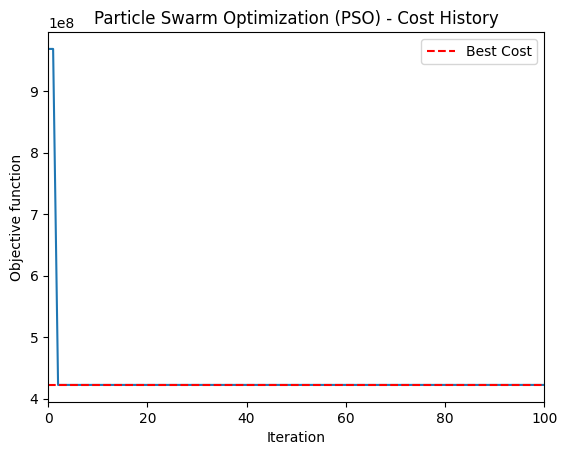

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 422134793.31736124
Tempo de Convergência para a segunda etapa: 1.340195655822754 segundos


In [193]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')

# Adicionar uma linha horizontal no custo ótimo
plt.axhline(optimal_cost / 1.000, color='red', linestyle='--', label='Best Cost')

# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

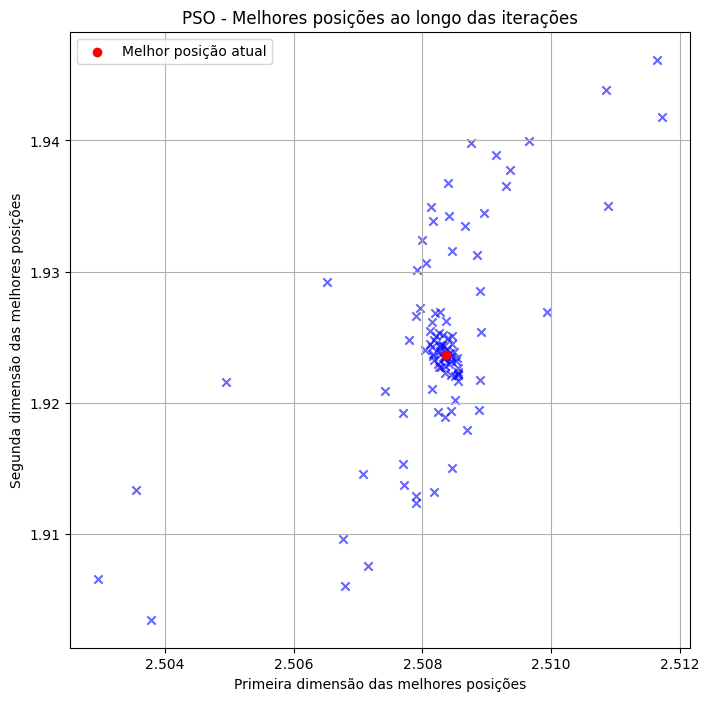

In [194]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [195]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [196]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(nome_arquivo, sep=",")
df.head()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa
0,1,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196


In [197]:
df.describe()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa
count,1.0,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000
mean,1.0,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196
25%,1.0,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196
50%,1.0,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196
75%,1.0,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196
max,1.0,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196


In [198]:
# Seus arrays de tempos e severidade
Tempos = [
    [205, 374, 538],
    [129, 244, 357, 508],
    [150, 256, 387, 543],
    [139, 277, 404, 575],
    [176, 305, 388, 541],
    [132, 247, 370, 520],
    [122, 229, 391, 547],
    [165, 305, 406, 534],
    [128, 261, 401, 556],
    [136, 250, 382, 529]
]

severidade = [
    [1.0, 1.0, 0.25],
    [1.0, 1.0, 1.0, 0.25],
    [1.0, 1.0, 1.0, 0.25],
    [1.0, 1.0, 1.0, 0.25],
    [1.0, 1.0, 1.0, 0.25],
    [1.0, 1.0, 1.0, 0.25],
    [1.0, 1.0, 1.0, 0.25],
    [1.0, 1.0, 1.0, 0.25],
    [1.0, 1.0, 1.0, 0.75],
    [1.0, 1.0, 1.0, 0.25]
]

# Verifique se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_CICLO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Número de ciclos de manutenção, Tempos para manutenções preventivas, Severidade para cada subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(",".join(row_str) + "\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")
